In [1]:
#https://www.kaggle.com/huanntran100/spotify-song-popularity-prediction/data

In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns
from scipy import stats
import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import plotnine
from plotnine import *
import itertools
import math
from prettytable import PrettyTable
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import plot_roc_curve, balanced_accuracy_score
from xgboost import XGBClassifier
from scipy.spatial import distance
from imblearn.over_sampling import SMOTE
import copy
import warnings
warnings.filterwarnings("ignore")
plotly.offline.init_notebook_mode(connected = True)
%matplotlib inline
sns.set(style = "ticks", context = "talk")

# Read Data

In [ ]:
data = pd.read_csv("/content/SpotifyFeatures.csv")
data.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Opera,Giuseppe Verdi,"Stiffelio, Act III: Ei fugge! … Lina, pensai c...",7EsKYeHtTc4H4xWiTqSVZA,21,0.986,0.313,490867,0.23100,0.000431,C#,0.0964,-14.287,Major,0.0547,86.001,4/4,0.0886
1,Opera,Giacomo Puccini,Madama Butterfly / Act 1: ... E soffitto e pareti,7MfmRBvqaW0I6UTxXnad8p,18,0.972,0.360,176797,0.20100,0.028000,D#,0.1330,-19.794,Major,0.0581,131.798,4/4,0.3690
2,Opera,Giacomo Puccini,"Turandot / Act 2: Gloria, gloria, o vincitore",7pBo1GDhIysyUMFXiDVoON,10,0.935,0.168,266184,0.47000,0.020400,C,0.3630,-8.415,Major,0.0383,75.126,3/4,0.0696
3,Opera,Giuseppe Verdi,"Rigoletto, Act IV: Venti scudi hai tu detto?",02mvYZX5aKNzdqEo6jF20m,17,0.961,0.250,288573,0.00605,0.000000,D,0.1200,-33.440,Major,0.0480,76.493,4/4,0.0380
4,Opera,Giuseppe Verdi,"Don Carlo / Act 4: ""Ella giammai m'amò!""",03TW0jwGMGhUabAjOpB1T9,19,0.985,0.142,629760,0.05800,0.146000,D,0.0969,-23.625,Major,0.0493,172.935,4/4,0.0382


# EDA

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228159 entries, 0 to 228158
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             228159 non-null  object 
 1   artist_name       228159 non-null  object 
 2   track_name        228159 non-null  object 
 3   track_id          228159 non-null  object 
 4   popularity        228159 non-null  int64  
 5   acousticness      228159 non-null  float64
 6   danceability      228159 non-null  float64
 7   duration_ms       228159 non-null  int64  
 8   energy            228159 non-null  float64
 9   instrumentalness  228159 non-null  float64
 10  key               228159 non-null  object 
 11  liveness          228159 non-null  float64
 12  loudness          228159 non-null  float64
 13  mode              228159 non-null  object 
 14  speechiness       228159 non-null  float64
 15  tempo             228159 non-null  float64
 16  time_signature    22

In [ ]:
data.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,228159.000000,228159.000000,228159.000000,2.281590e+05,228159.000000,228159.000000,228159.000000,228159.000000,228159.000000,228159.000000,228159.000000
mean,44.209130,0.351200,0.554198,2.366092e+05,0.580967,0.137310,0.214638,-9.354658,0.122442,117.423062,0.444795
std,17.276599,0.351385,0.183949,1.166787e+05,0.260577,0.292447,0.196977,5.940994,0.186264,30.712458,0.255397
min,0.000000,0.000001,0.056900,1.550900e+04,0.000020,0.000000,0.009670,-52.457000,0.022200,30.379000,0.000000
25%,33.000000,0.030900,0.437000,1.862530e+05,0.405000,0.000000,0.097700,-11.287000,0.036800,92.734000,0.232000
50%,47.000000,0.205000,0.570000,2.211730e+05,0.618000,0.000037,0.128000,-7.515000,0.050600,115.347000,0.430000
75%,57.000000,0.689000,0.690000,2.648400e+05,0.793000,0.023400,0.263000,-5.415000,0.109000,138.887000,0.643000
max,100.000000,0.996000,0.987000,5.552917e+06,0.999000,0.999000,1.000000,1.585000,0.967000,239.848000,1.000000


In [ ]:
data.isnull().sum()

genre               0
artist_name         0
track_name          0
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

In [ ]:
data.columns

Index(['genre', 'artist_name', 'track_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')

In [ ]:
# get rid of tracks too long or too short
data = data[np.abs(stats.zscore(data['duration_ms'])) <= 3]
data.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,225869.000000,225869.000000,225869.000000,225869.000000,225869.000000,225869.000000,225869.000000,225869.000000,225869.000000,225869.000000,225869.000000
mean,44.384214,0.347368,0.556231,229907.312429,0.583432,0.134357,0.214078,-9.281458,0.121667,117.561692,0.447018
std,17.211508,0.349593,0.182760,77872.600766,0.259162,0.289663,0.195972,5.885433,0.184248,30.706596,0.254714
min,0.000000,0.000001,0.057000,15509.000000,0.000020,0.000000,0.009670,-52.457000,0.022200,30.379000,0.000000
25%,33.000000,0.030300,0.440000,185867.000000,0.409000,0.000000,0.097800,-11.170000,0.036800,92.955000,0.235000
50%,47.000000,0.201000,0.572000,220453.000000,0.620000,0.000034,0.129000,-7.481000,0.050700,115.672000,0.433000
75%,57.000000,0.677000,0.691000,262933.000000,0.794000,0.020800,0.263000,-5.399000,0.109000,139.028000,0.645000
max,100.000000,0.996000,0.987000,586588.000000,0.999000,0.999000,1.000000,1.585000,0.967000,239.848000,1.000000


In [ ]:
numeric_data = data._get_numeric_data()
numeric_data.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,21,0.986,0.313,490867,0.23100,0.000431,0.0964,-14.287,0.0547,86.001,0.0886
1,18,0.972,0.360,176797,0.20100,0.028000,0.1330,-19.794,0.0581,131.798,0.3690
2,10,0.935,0.168,266184,0.47000,0.020400,0.3630,-8.415,0.0383,75.126,0.0696
3,17,0.961,0.250,288573,0.00605,0.000000,0.1200,-33.440,0.0480,76.493,0.0380
5,20,0.990,0.211,334720,0.06400,0.019600,0.0730,-20.666,0.0534,81.403,0.0400


In [ ]:
# Split data features by type
numeric_audio_features = numeric_data.drop(['popularity', 'duration_ms'], axis=1)
other_numeric_features = data[['duration_ms']]

categorical_audio_features = data[['mode', 'key', 'time_signature']]
other_categorical_features = data[['genre', 'artist_name']]

In [ ]:
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

In [ ]:
# sns.pairplot(data.sample(1000),corner=True,hue='genre')

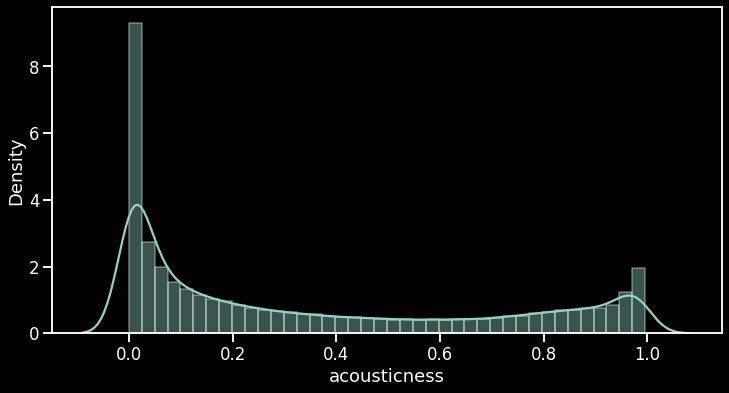

In [ ]:
plt.figure(figsize=(12, 6))
sns.distplot(numeric_audio_features.acousticness, bins=40)

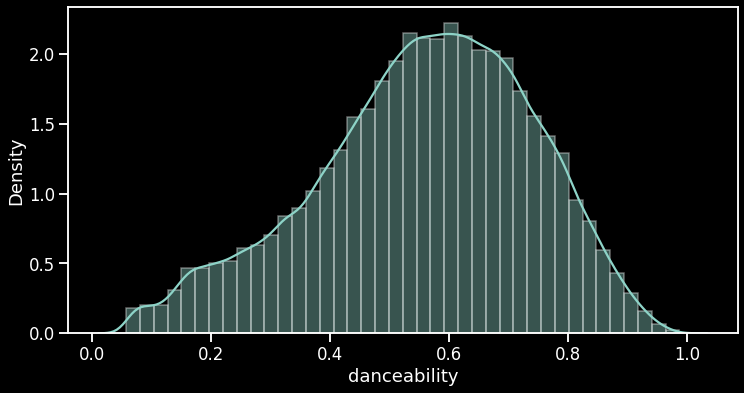

In [ ]:
plt.figure(figsize=(12, 6))
sns.distplot(numeric_audio_features.danceability, bins=40)

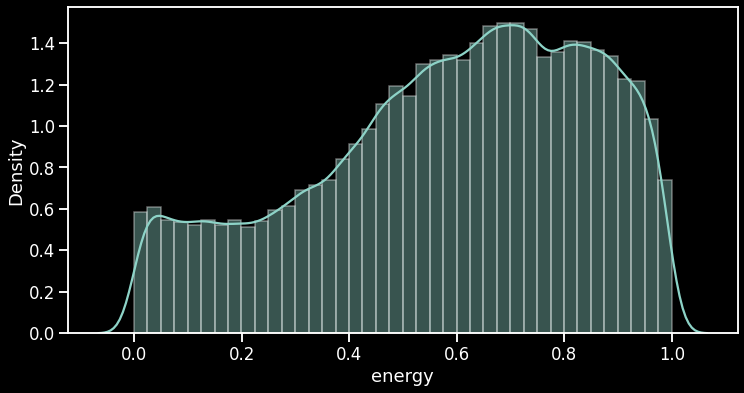

In [ ]:
plt.figure(figsize=(12, 6))
sns.distplot(numeric_audio_features.energy, bins=40)

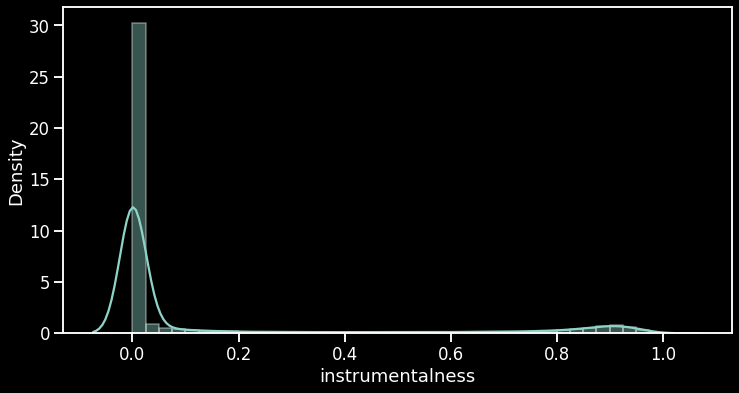

In [ ]:
plt.figure(figsize=(12, 6))
sns.distplot(numeric_audio_features.instrumentalness, bins=40)

In [ ]:
numeric_audio_features.instrumentalness[numeric_audio_features.instrumentalness < 0.5 ].count() / len(numeric_audio_features)

0.8595911789577144

In [ ]:
# Drop instrumentalness 
numeric_audio_features = numeric_audio_features.drop(['instrumentalness'], axis=1)

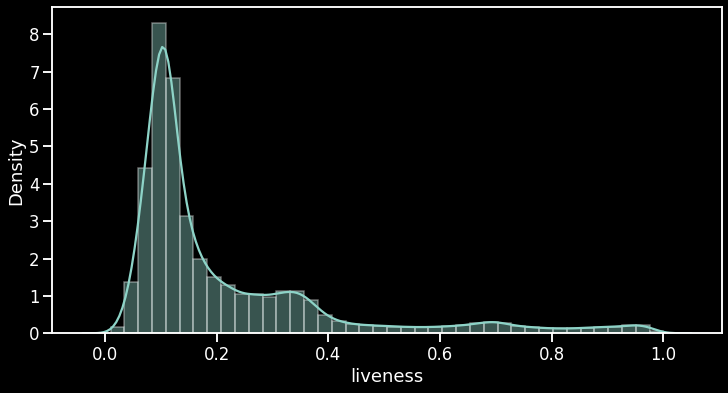

In [ ]:
plt.figure(figsize=(12, 6))
sns.distplot(numeric_audio_features.liveness, bins=40)

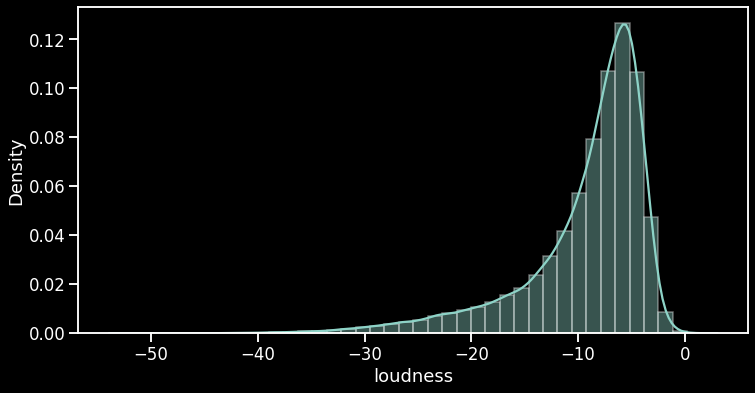

In [ ]:
plt.figure(figsize=(12, 6))
sns.distplot(numeric_audio_features.loudness, bins=40)

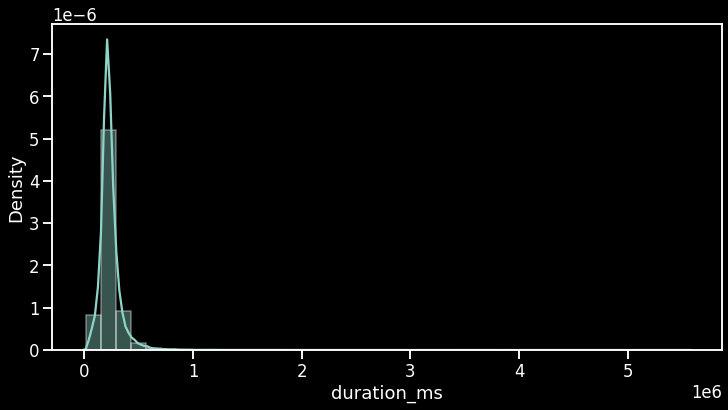

In [ ]:
# Before dropping long songs
plt.figure(figsize=(12, 6))
sns.distplot(pd.read_csv("/content/SpotifyFeatures.csv").duration_ms, bins=40)

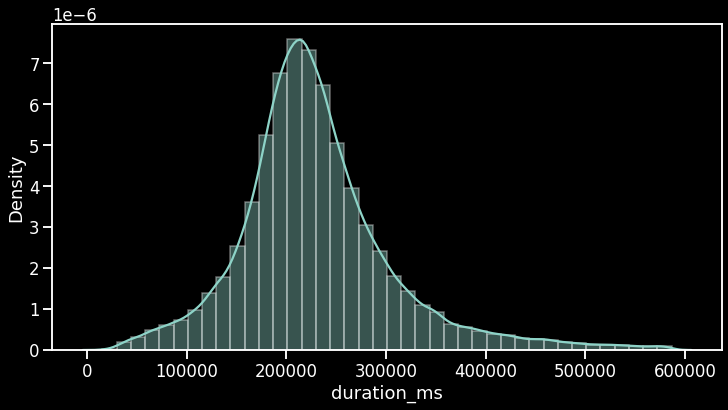

In [ ]:
plt.figure(figsize=(12, 6))
sns.distplot(other_numeric_features.duration_ms, bins=40)

In [ ]:
print(data.columns)
print(numeric_audio_features.columns)
print(other_numeric_features.columns)
print(categorical_audio_features.columns)
print(other_categorical_features.columns)

Index(['genre', 'artist_name', 'track_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')
Index(['acousticness', 'danceability', 'energy', 'liveness', 'loudness',
       'speechiness', 'tempo', 'valence'],
      dtype='object')
Index(['duration_ms'], dtype='object')
Index(['mode', 'key', 'time_signature'], dtype='object')
Index(['genre', 'artist_name'], dtype='object')


In [ ]:
categorical_audio_features

,mode,key,time_signature
0,Major,C#,4/4
1,Major,D#,4/4
2,Major,C,3/4
3,Major,D,4/4
5,Major,G#,3/4
...,...,...,...
228154,Minor,F#,4/4
228155,Major,A,4/4
228156,Minor,C,4/4
228157,Minor,E,5/4


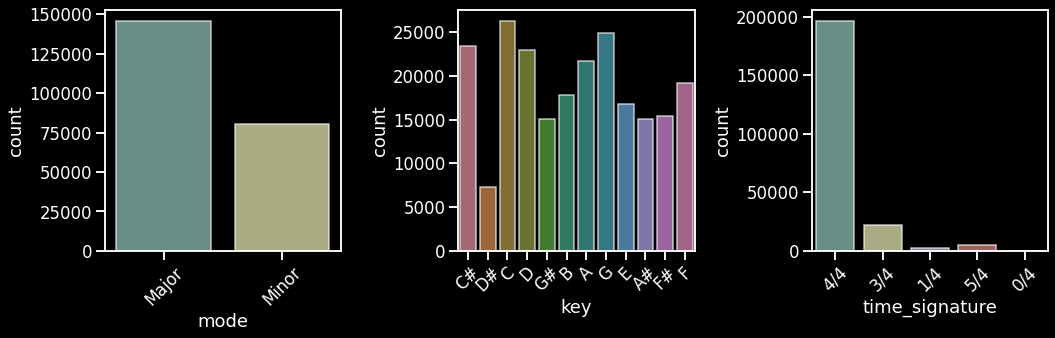

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(fig.axes):
    if i < len(categorical_audio_features.columns):
        ax.tick_params(axis='x', rotation=45)
        sns.countplot(x=categorical_audio_features.columns[i], alpha=0.7, data=categorical_audio_features, ax=ax)

fig.tight_layout()

In [ ]:
# Drop time_signature 
perc = categorical_audio_features.time_signature[categorical_audio_features.time_signature == "4/4" ].count() / len(categorical_audio_features)
print(perc)
categorical_audio_features = categorical_audio_features.drop(['time_signature'], axis=1)


0.8695040045336013


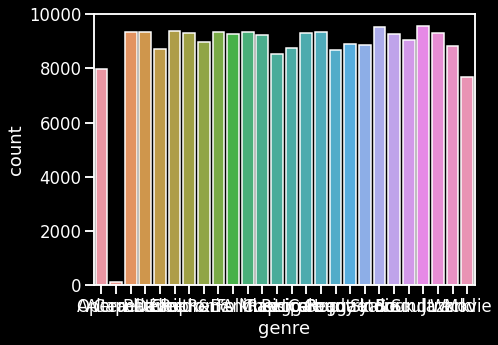

In [ ]:
plt.figure(figsize =(15,5))

ax1 = plt.subplot(1,2,1)
sns.countplot(x = other_categorical_features["genre"], data=other_categorical_features)

# ax2 = plt.subplot(1,2,2)
# sns.countplot(x=topdata["genre"], data=topdata)

In [ ]:
other_categorical_features.groupby('genre').count()

,artist_name
genre,
A Capella,119
Alternative,9347
Anime,9347
Blues,9347
Children’s Music,9347
Classical,8520
Comedy,9354
Country,8661
Dance,8699


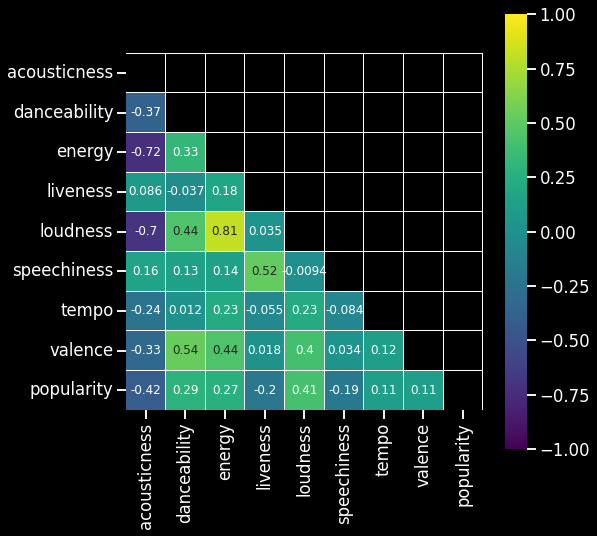

In [ ]:
numeric_audio_features_label = numeric_audio_features
numeric_audio_features_label['popularity'] = data['popularity']
corr = numeric_audio_features.corr()

fig, ax = plt.subplots(figsize=(8,8)) 
ax = sns.heatmap(corr, mask=np.triu(corr),
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 12}, square=True);




In [ ]:
# Energy and loudness is highly corelated, and loundness is more corelated to popularity, so drop energy 
numeric_audio_features = numeric_audio_features.drop(['energy'], axis=1)


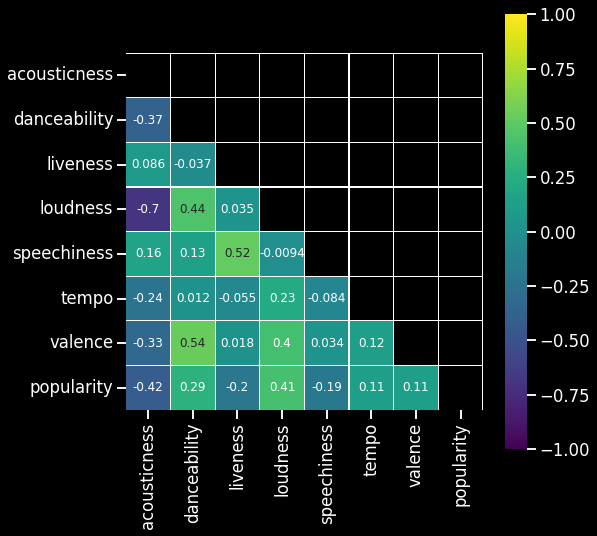

In [ ]:
numeric_audio_features_label = numeric_audio_features
numeric_audio_features_label['popularity'] = data['popularity']
corr = numeric_audio_features.corr()

fig, ax = plt.subplots(figsize=(8,8)) 
ax = sns.heatmap(corr, mask=np.triu(corr),
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 12}, square=True);

In [ ]:
data.groupby("genre").popularity.mean().sort_values(ascending = False)

genre
Pop                 66.592837
Rap                 60.537352
Rock                59.627188
Hip-Hop             58.423280
Dance               57.276469
Indie               54.701604
Alternative         54.660105
Anime               54.660105
Blues               54.660105
Children’s Music    54.660105
R&B                 52.309815
Folk                49.955870
Soul                47.023397
Country             46.100797
Jazz                40.841901
Electronic          38.059020
Reggaeton           37.772804
Reggae              35.605305
World               35.588022
Soundtrack          33.946365
Classical           29.494836
Ska                 28.616513
Comedy              21.309707
Opera               13.331660
Movie               12.279349
A Capella            9.302521
Name: popularity, dtype: float64

In [ ]:
data.groupby("artist_name").popularity.mean().sort_values(ascending = False).head(10)

artist_name
Pedro Capó              87.000000
Mario Bautista          85.000000
Mau y Ricky             83.000000
Paloma Mami             82.000000
Ninho                   82.000000
Kris Kross Amsterdam    82.000000
Martin Garrix           81.857143
Sofia Reyes             81.500000
NSG                     81.000000
Heuss L'enfoiré         81.000000
Name: popularity, dtype: float64

*   Energy and loundness is moderately/highly positively correlated.
*   Energy and acousticness is moderately negatively correlated.
*   Speechiness and Instrumentalness is moderately negatively correlated.
*   Valence and danceability is moderately positively correlated.



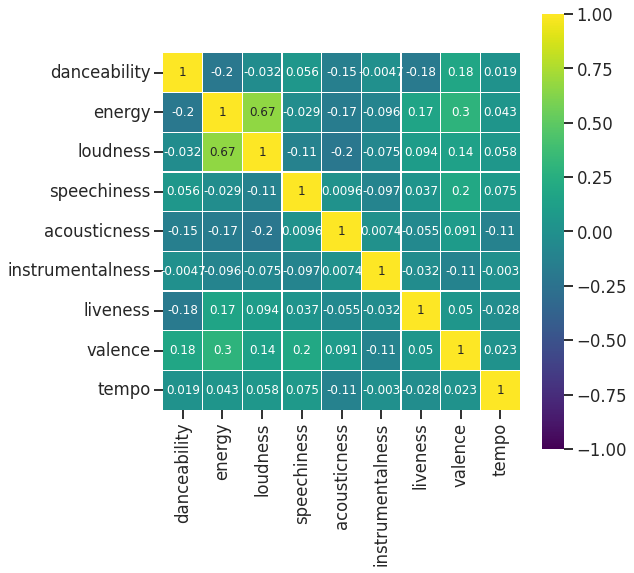

In [ ]:
corr = continuous_numeric_data_genre[continuous_numeric_data_genre["genre"] == "Rap"].corr()
fig, ax = plt.subplots(figsize=(8,8)) 
ax = sns.heatmap(corr, 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 12}, square=True);

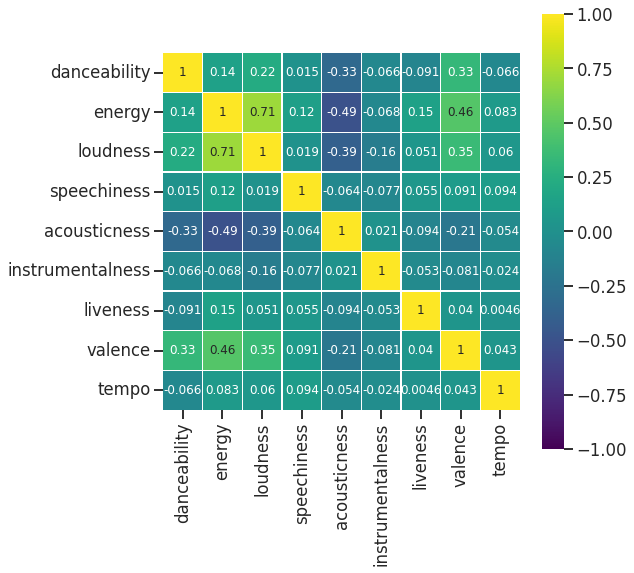

In [ ]:
corr = continuous_numeric_data_genre[continuous_numeric_data_genre["genre"] == "RnB"].corr()
fig, ax = plt.subplots(figsize=(8,8)) 
ax = sns.heatmap(corr, 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 12}, square=True);

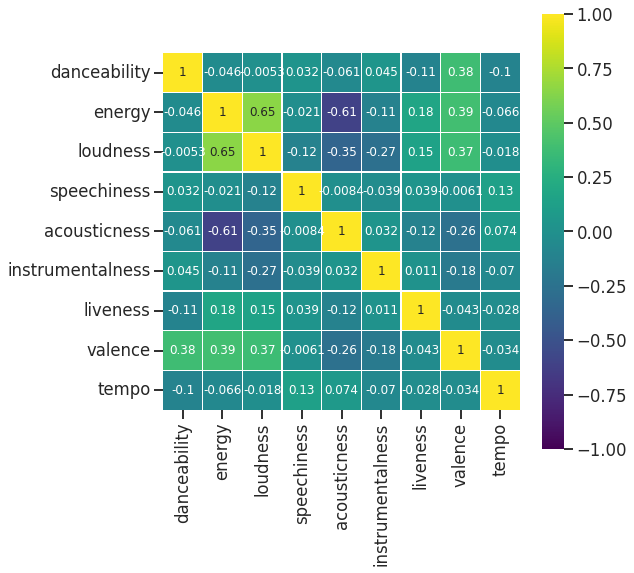

In [ ]:
corr = continuous_numeric_data_genre[continuous_numeric_data_genre["genre"] == "Pop"].corr()
fig, ax = plt.subplots(figsize=(8,8)) 
ax = sns.heatmap(corr, 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 12}, square=True);

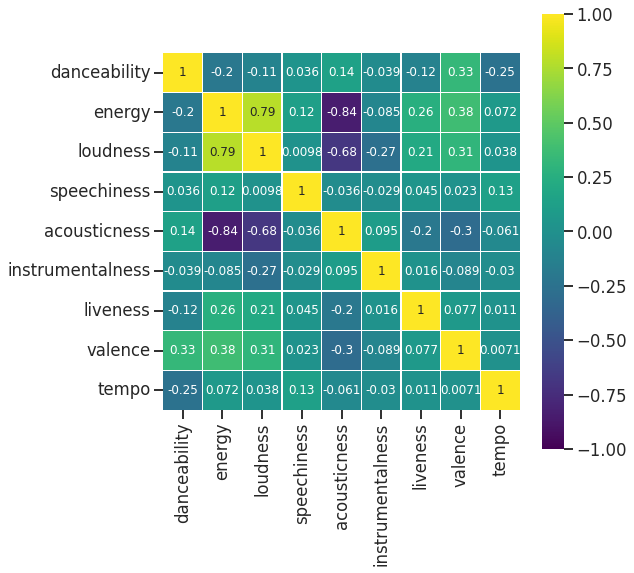

In [ ]:
corr = continuous_numeric_data_genre[continuous_numeric_data_genre["genre"] == "Emo"].corr()
fig, ax = plt.subplots(figsize=(8,8)) 
ax = sns.heatmap(corr, 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 12}, square=True);

In [ ]:

# normalized_df=(df-df.mean())/df.std()

import pandas as pd
df = pd.read_csv("/content/SpotifyFeatures.csv")




In [ ]:
from sklearn import preprocessing
numeric_data = df._get_numeric_data()

scaler = preprocessing.MinMaxScaler()
names = numeric_data.columns
d = scaler.fit_transform(numeric_data)
scaled_df = pd.DataFrame(d, columns=names)
scaled_df.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.21,0.989960,0.275347,0.085845,0.231216,0.000431,0.087577,0.706303,0.034399,0.265538,0.0886
1,0.18,0.975904,0.325879,0.029127,0.201185,0.028028,0.124534,0.604400,0.037997,0.484172,0.3690
2,0.10,0.938755,0.119450,0.045269,0.470460,0.020420,0.356780,0.814959,0.017041,0.213621,0.0696
3,0.17,0.964859,0.207612,0.049313,0.006036,0.000000,0.111407,0.351893,0.027307,0.220147,0.0380
4,0.19,0.988956,0.091496,0.110928,0.058039,0.146146,0.088082,0.533511,0.028683,0.680559,0.0382


In [ ]:


numeric_data = scaled_df[np.abs(stats.zscore(df['duration_ms'])) <= 3]
numeric_audio_features = scaled_df.drop(['popularity'], axis=1)
popularity = scaled_df[['popularity']]
categorical_audio_features = df[['mode', 'key', 'time_signature', 'genre']]



In [ ]:
names = categorical_audio_features.columns
encoder = preprocessing.OrdinalEncoder()
# transform data
result = encoder.fit_transform(categorical_audio_features)
encoded_df = pd.DataFrame(result, columns=names)
encoded_df.head()

,mode,key,time_signature,genre
0,0.0,4.0,3.0,15.0
1,0.0,6.0,3.0,15.0
2,0.0,3.0,2.0,15.0
3,0.0,5.0,3.0,15.0
4,0.0,5.0,3.0,15.0


In [ ]:
combined_df = pd.concat([numeric_audio_features, encoded_df], axis=1)
combined_df.head()
# combined_df = combined_df.drop(['genre'],axis =1)


,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,mode,key,time_signature,genre
0,0.989960,0.275347,0.085845,0.231216,0.000431,0.087577,0.706303,0.034399,0.265538,0.0886,0.0,4.0,3.0,15.0
1,0.975904,0.325879,0.029127,0.201185,0.028028,0.124534,0.604400,0.037997,0.484172,0.3690,0.0,6.0,3.0,15.0
2,0.938755,0.119450,0.045269,0.470460,0.020420,0.356780,0.814959,0.017041,0.213621,0.0696,0.0,3.0,2.0,15.0
3,0.964859,0.207612,0.049313,0.006036,0.000000,0.111407,0.351893,0.027307,0.220147,0.0380,0.0,5.0,3.0,15.0
4,0.988956,0.091496,0.110928,0.058039,0.146146,0.088082,0.533511,0.028683,0.680559,0.0382,0.0,5.0,3.0,15.0


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(combined_df, popularity, test_size=0.25)

linRegressionModel = LinearRegression().fit(X_train,y_train)

In [ ]:
linRegressionModel.coef_
combined_df.columns
coefs = pd.DataFrame(
    linRegressionModel.coef_,
    columns=combined_df.columns
)

coefs.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,mode,key,time_signature,genre
0,-0.116257,0.151081,-0.156517,-0.101945,-0.027388,-0.097094,0.471836,-0.1078,0.015144,-0.082159,0.012852,0.000339,0.011645,-0.003707


In [ ]:
linRegressionModel.score(X_test, y_test)

0.3071579371800849

In [ ]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
# can we identify clusters in data?
# dropping genre as intuitively the clusters should represent the genres themselves
genre_df = combined_df.drop(['genre'], axis=1)
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(genre_df, popularity, test_size=0.25)

for i in range(2,20):
  kmeans = KMeans(n_clusters = i).fit(X_train_g)
  gmm = GaussianMixture(n_components = i).fit(X_train_g)
  score_k = kmeans.score(X_test_g)
  score_g = gmm.score(X_test_g)
  print(str(i) + ": " + str(score_k) + " " +str(score_g))


2: -203442.77441201312 7.686332124575956
3: -122942.33165486946 10.79287485704516
4: -85666.22133709543 11.149942541810875
5: -71553.803404434 11.619553832660662
6: -63634.42292256848 11.686507408504598
7: -61117.811825977136 12.16457927492717
8: -58516.38176551639 11.793598813690382
9: -55280.6923038054 14.981060822700352
10: -53708.8068780827 11.406092740555135
11: -51875.35213318953 15.588013926499814
12: -49136.73339867544 12.51151235633327
13: -48170.80895901835 14.841486933373718
14: -46045.6496232366 16.712669883670113
15: -44869.09760992165 16.87653224552422
16: -43953.03874831492 16.985980480878442
17: -42354.074093367155 16.996662766821395
18: -41249.092240059625 15.347998629402
19: -40442.290310011755 18.27491431384309


In [ ]:
combined_df_2 = pd.concat([combined_df, popularity], axis=1)
for i in range(0,16):
  genre_df = combined_df_2.loc[combined_df_2['genre'] == float(i)]
  
  popularity_g = genre_df[['popularity']]
  genre_df = genre_df.drop(['genre', 'popularity'],axis = 1)
  X_train, X_test, y_train, y_test = train_test_split(genre_df, popularity_g, test_size=0.25)
  linRegressionModel = LinearRegression().fit(X_train,y_train)
  print(linRegressionModel.score(X_test,y_test), encoder.inverse_transform([[0,0,0,i]])[-1][-1], len(X_train))

  
#splitting predictions by genre seems like its horrible, sample size too small? 
# or maybe genre itself is an important predictor of popularity. 
# not sure what's going on here tbh



0.22636502336021044 A Capella 89
0.009516612882106588 Alternative 7014
0.015343088234317072 Anime 7014
0.011064000759006598 Blues 7014
0.02370200791172894 Children’s Music 7014
0.12565946569896214 Classical 6942
0.0846101403833277 Comedy 7260
0.010167118926179497 Country 6498
0.01710574763727979 Dance 6525
0.025712344160716664 Electronic 7032
0.015527474802100039 Folk 6974
0.02888748749970016 Hip-Hop 6971
0.014182082464457846 Indie 7157
0.024876784992943435 Jazz 7080
0.06642495247311508 Movie 5854
0.022407627514529738 Opera 6210


In [ ]:
# This suggests that the model still works (albeit a little worse) when removing genre as a feature overall...
# either the code I did in the cell above is messed up, or the sample size is too small when making one model 
# per genre

combined_df_3 = combined_df.drop(['genre'],axis = 1)
combined_df_3
X_train, X_test, y_train, y_test = train_test_split(combined_df_3, popularity, test_size=0.25)
linRegressionModel = LinearRegression().fit(X_train,y_train)
print(linRegressionModel.score(X_test,y_test))



0.28453514765192


In [ ]:
from sklearn.svm import SVC
genre = combined_df.loc

genre = combined_df[['genre']]
combined_df_4 = combined_df.drop(['genre'],axis = 1)
X_train, X_test, y_train, y_test = train_test_split(combined_df_4, genre, test_size=0.25)

svcModel = SVC(kernel='linear').fit(X_train,y_train)

In [ ]:
svcModel.score(X_test,y_test)

0.29356591865357645